
#Arcface Demonstration
in Tensorflow 
Use Modified version for Tensorflow (not original paper)

First: Download The Git Repo

In [ ]:
%%capture
!git clone https://github.com/peteryuX/arcface-tf2.git
%cd /content/arcface-tf2 
!pip install -r requirements.txt

Download Pretrained Network 
More are available on the github, also a deeper resnet 100, this is the smallest.

ResNet50: 50 Layers Residual Network 

In [ ]:
%%capture
!pip install gdown
!gdown --id 1HasWQb86s4xSYy36YbmhRELg9LBmvhvt 
!unzip arc_res50.zip
!mkdir checkpoints
!mv arc_res50 checkpoints/arc_res50
!rm arc_res50.zip

#Data preparation
Download Various Databases, all precropped and ready to use.
Source: https://github.com/ZhaoJ9014/face.evoLVe.PyTorch#Data-Zoo
###LFW: Labelled Faces in the Wild
 http://vis-www.cs.umass.edu/lfw/

###AgeDB30 
https://ibug.doc.ic.ac.uk/resources/agedb/
###CFP-FP: Celebrities in Frontal Profile 
http://www.cfpw.io/


(Might take a while, about 4 Gig)

In [ ]:
%%capture
%cd /content/arcface-tf2/data
!gdown --id 1WO5Meh_yAau00Gm2Rz2Pc0SRldLQYigT #LFW
!unzip lfw_align_112.zip
!rm lfw_align_112.zip
print("Downloaded LFW")
!gdown --id 1AoZrZfym5ZhdTyKSxD0qxa7Xrp2Q1ftp #AGEDB
!unzip agedb_align_112.zip 
!rm agedb_align_112.zip 
# No idea why, but the downloaded DB has Wrong Name, correcting that here
!mv /content/arcface-tf2/data/AgeDB /content/arcface-tf2/data/agedb_align_112
print("Downloaded AGEDB")
!gdown --id 1-sDn79lTegXRNhFuRnIRsgdU88cBfW6V #CFP 
!unzip cfp_align_112.zip
!rm cfp_align_112.zip
print("Downloaded CFP")

# Encode single Image
Encode Bruce Lee (found in the github), visualize Encoding 

/content/arcface-tf2
2020-06-18 17:41:55.187860: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 17:41:55.188065: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 17:41:55.188094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0618 17:42:00.457489 139994047920000 utils.py:18] Detect 1 Physical GPUs, 1 Logical GPUs.
94773248/94765736 [==============================] - 1s 0us/step
[*] load ckpt from ./checkpoints

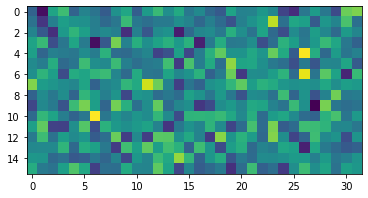

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%cd /content/arcface-tf2
!python test.py --cfg_path="./configs/arc_res50.yaml" --img_path="./data/BruceLee.jpg"
encoded = np.load('./output_embeds.npy')
print(encoded.shape)
#print(encoded)
encoded = encoded[0]
encoded.shape
img = np.reshape(encoded, (-1, 32))
plt.imshow(img)

<Figure size 432x288 with 0 Axes>

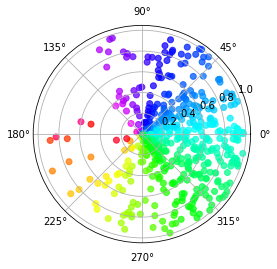

In [ ]:
plt.figure()
thetas = encoded * 25 
np.random.seed(1)
r = np.random.rand(512)

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

c = ax.scatter(thetas, r, c = thetas, cmap='hsv', alpha=0.75)
plt.show()

# Take Photos to create Individual Test
Ignore This, helper function to take pictures

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#Photoshoot
Here, you take 2 Pictures, the first the network will learn, the second will be used as a test

/content/arcface-tf2/data
Please take a reference photo


<IPython.core.display.Javascript object>

Saved to Allie.jpg


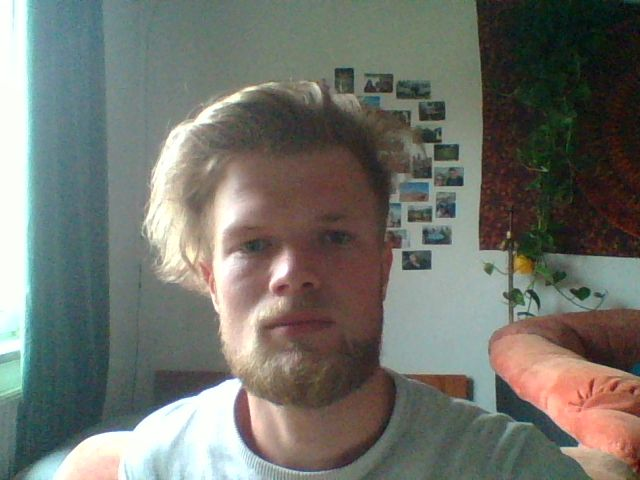

Please take a test photo


<IPython.core.display.Javascript object>

Saved to Bjarne.jpg


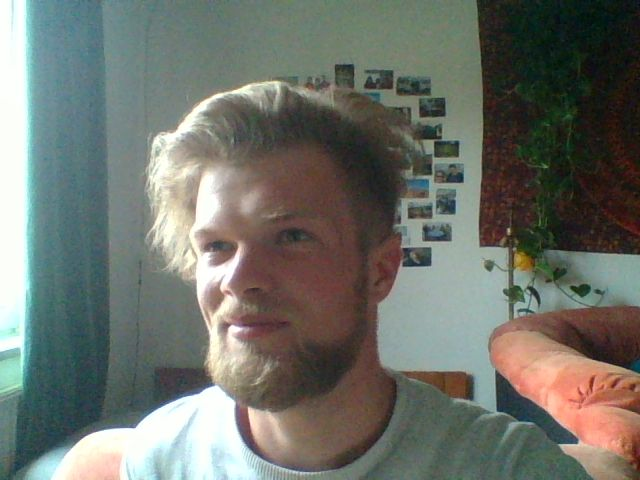

In [ ]:
%cd /content/arcface-tf2/data
from IPython.display import Image
try:
  # Take Reference Photo
  print('Please take a reference photo')
  filename = take_photo(filename = 'Allie.jpg')
  print('Saved to {}'.format(filename))
  display(Image(filename))
  # Take Test Photo with either same or different person
  print('Please take a test photo')
  filename = take_photo(filename = 'Bjarne.jpg')
  print('Saved to {}'.format(filename))
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In Case You want to change network params


In [ ]:
%%writefile /content/arcface-tf2/configs/arc_res50.yaml
# general
batch_size: 128
input_size: 112
embd_shape: 512
sub_name: 'arc_res50'
backbone_type: 'ResNet50' # 'ResNet50', 'MobileNetV2'
head_type: ArcHead # 'ArcHead', 'NormHead'
is_ccrop: False # central-cropping or not

# train
train_dataset: './data/ms1m_bin.tfrecord'
binary_img: True
num_classes: 85742
num_samples: 5822653
epochs: 5
base_lr: 0.01
w_decay: 0.1

# test
test_dataset: '/content/arcface-tf2/data/'

Overwriting /content/arcface-tf2/configs/arc_res50.yaml


Test Performance on the 3 Benchmark Databases
---
* LFW : Labeled Faces Iín the Wild
http://vis-www.cs.umass.edu/lfw/
* AgeDB30
https://ibug.doc.ic.ac.uk/resources/agedb/
* CFP-FP: Celebrities in Frontal Profile
http://www.cfpw.io/

th = biggest theta
acc = accuracy on Dataset


In [ ]:
%cd /content/arcface-tf2
!python test.py --cfg_path="/content/arcface-tf2/configs/arc_res50.yaml"

/content/arcface-tf2
2020-06-18 17:43:21.857777: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 17:43:21.858045: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 17:43:21.858078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0618 17:43:23.674346 140257528276864 utils.py:18] Detect 1 Physical GPUs, 1 Logical GPUs.
[*] load ckpt from ./checkpoints/arc_res50/e_8_b_40000.ckpt
[*] Loading LFW, AgeDB30 and CFP-FP..

#Initialize and Compile the model

In [ ]:
import modules.models
from modules.models import ArcFaceModel

model = ArcFaceModel(size=112,
                         backbone_type='ResNet50',
                         training=False)
model.summary()

Model: "arcface_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 112, 112, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
OutputLayer (Model)          (None, 512)               16787968  
Total params: 40,375,680
Trainable params: 40,317,440
Non-trainable params: 58,240
_________________________________________________________________


In [ ]:
import tensorflow as tf

from modules.losses import SoftmaxLoss
opt = tf.keras.optimizers.SGD(
        learning_rate=0.01, 
        momentum=0.9, 
        nesterov=True)
model.compile(optimizer = opt, loss = SoftmaxLoss())

Encode the 2 Images by manually feeding images as numpy arrays

I mostly skimped on preprocessing, but it could be done here to enhance results. 
I do the bare minimum: 
* crop to size, 
* convert to float between 0 and 1, 
* add batch dimension

then feed to the model

In [ ]:
import cv2
from modules.utils import l2_norm
a = cv2.imread('/content/arcface-tf2/data/Allie.jpg')
b = cv2.imread('/content/arcface-tf2/data/Bjarne.jpg')

a = cv2.resize(a, (112, 112))
b = cv2.resize(b, (112, 112))

a = a.astype(np.float32) / 255.
b = b.astype(np.float32) / 255.
a = np.expand_dims(a, 0)
b = np.expand_dims(b, 0)
len(a.shape)
out_a = l2_norm(model(a))
out_b = l2_norm(model(b))

out_a = out_a[0].numpy()
out_b = out_b[0].numpy()

In [ ]:
a.shape

(1, 112, 112, 3)

In [ ]:
out_a.shape

(512,)

In [ ]:
from scipy import spatial
cos_similarity = 1 - spatial.distance.cosine(out_a, out_b)
print('Cosine Similarity',cos_similarity)
sameface = True if cos_similarity >= 0.8 else False
print("The Photos show the same person") if sameface else print("I think that is not the same person")

Cosine Similarity 0.9975948333740234
The Photos show the same person


Encode the 2 Images by utilizing the given scripts

In [ ]:
%cd /content/arcface-tf2
!python test.py --cfg_path="/content/arcface-tf2/configs/arc_res50.yaml" --img_path="/content/arcface-tf2/data/Allie.jpg"
a_encoded = np.load('./output_embeds.npy')
!python test.py --cfg_path="/content/arcface-tf2/configs/arc_res50.yaml" --img_path="/content/arcface-tf2/data/Bjarne.jpg"
b_encoded = np.load('./output_embeds.npy')
print(encoded.shape)

# Compute Spatial distance between Images

from scipy import spatial
from scipy.spatial.distance import cdist

euclid =  cdist(a_encoded, b_encoded,'euclidean')
print('Euclidean Distance', euclid)
cos_similarity = 1 - spatial.distance.cosine(a_encoded, b_encoded)
print('Cosine Similarity',cos_similarity)
sameface = True if cos_similarity >= 0.7 else False
print("The Photos show the same person") if sameface else print("I think that is not the same person")

/content/arcface-tf2
2020-06-18 17:49:41.751112: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 17:49:41.751255: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 17:49:41.751283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0618 17:49:43.378162 140179708270464 utils.py:18] Detect 1 Physical GPUs, 1 Logical GPUs.
[*] load ckpt from ./checkpoints/arc_res50/e_8_b_40000.ckpt
[*] Encode /content/arcface-tf2/data/

As an alternative, we can also compare the output with the face_recognition module, but generally cosine similarity should be okay

In [ ]:
!pip install face_recognition
import face_recognition as fr
dist = fr.face_distance(a_encoded, b_encoded)
print('Euclidean distance:', dist, 'The images are similar' if dist < .8 else 'The images are not Similar')

     |████████████████████████████████| 100.2MB 68kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=b37dbb020cee7559074fdc679627b7cd742b0b07e9d97066223f09297ac2ae6d
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models
Euclidean distance: [0.6462435] The images are similar


Here, you can see the output again compared in the more intuitive "Fingerprint Plot" where the embedding gets located and color-coded based on the theta-value

<Figure size 432x288 with 0 Axes>

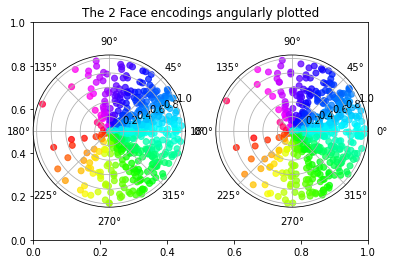

In [ ]:
plt.figure()
thetas_a = out_a * 25
thetas_b = out_b * 25
np.random.seed(1)
r = np.random.rand(512)
# if you dont want a random radius, uncomment the line below
#r = np.ones(512)
fig = plt.figure()
plt.title('The 2 Face encodings angularly plotted')
ax = fig.add_subplot(121, projection='polar')
ax.scatter(thetas_a, r, c = thetas_a, cmap='hsv', alpha=0.75)
ax = fig.add_subplot(122, projection='polar')
ax.scatter(thetas_b, r, c = thetas_b, cmap='hsv', alpha=0.75)
plt.show()